Import packages

In [45]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import random
import matplotlib.pyplot as plt
from pathlib import Path
import json

In [10]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/main/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/main/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/main/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
# Example usage
text = Path('data/small_corpus.txt').read_text(encoding='utf-8')

In [8]:
def extract_unique_words(text):
    # Lowercase and tokenize the text
    text = text.lower()
    words = word_tokenize(text)

    # Remove punctuation
    words = [word for word in words if word.isalpha()]

    # Count the number of words and unique words
    print("# of words in the text: ", len(words))

    unique_words = sorted(set(words))
    print("# of unqiue words in the text: ", len(unique_words))

    return unique_words

In [11]:
unique_words = extract_unique_words(text)

# of words in the text:  210000
# of unqiue words in the text:  20


In [15]:
def generate_cbows(text, window_size):
    # Lowercase and tokenize the text
    text = text.lower()
    words = word_tokenize(text)

    # Remove punctuation
    words = [word for word in words if word.isalpha()]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Create CBOW pairs with a given window size
    cbows = []
    for i, target_word in enumerate(words):
        context_words = words[max(0, i - window_size):i] + \
            words[i + 1:i + window_size + 1]
        if len(context_words) == window_size * 2:
            cbows.append((context_words, target_word))
    return cbows

In [16]:
# Create cbows
cbows = generate_cbows(text, window_size=3)

# Display the results
for context_words, target_word in cbows[:3]:
    print(f'Context Words: {context_words}, Target Word: {target_word}')

Context Words: ['pet', 'house', 'dog', 'play', 'animal', 'sleep'], Target Word: cat
Context Words: ['house', 'dog', 'cat', 'animal', 'sleep', 'pet'], Target Word: play
Context Words: ['dog', 'cat', 'play', 'sleep', 'pet', 'animal'], Target Word: animal


In [17]:
def one_hot_encoding(word, unique_words):
    encoding = [1 if word == w else 0 for w in unique_words]
    return torch.tensor(encoding, dtype=torch.float32)

In [18]:
# Create one-hot encodings for each word
one_hot_encodings = {word: one_hot_encoding(
    word, unique_words) for word in unique_words}
one_hot_encodings['king']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.])

In [19]:
# Convert CBOW pairs to vector pairs
cbow_vector_pairs = [([one_hot_encodings[word] for word in context_words],
                      one_hot_encodings[target_word]) for context_words, target_word in cbows]

In [20]:
cbow_vector_pairs[0][0]  # contains the 6 context word one-hot encoded vectors

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.]),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1.])]

In [21]:
cbow_vector_pairs[0][1]  # contains the center word as one-hot encoded vector

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [22]:
# Sum the context vectors to get a single context vector
cbow_vector_pairs = [(torch.sum(torch.stack(context_vectors), dim=0), target_vector)
                     for context_vectors, target_vector in cbow_vector_pairs]

In [23]:
cbow_vector_pairs[0]

(tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
         0., 1.]),
 tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [24]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.inputs = [item[0] for item in data]
        self.outputs = [item[1] for item in data]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sample = self.inputs[idx]
        output_sample = self.outputs[idx]
        return input_sample, output_sample

In [25]:
# Shuffle pairs before training
cbow_vector_pairs = random.sample(cbow_vector_pairs, len(cbow_vector_pairs))

# Train and Val split
split_index = int(len(cbow_vector_pairs) * 0.90)

# Split the data into training and test sets
train_dataset = CustomDataset(cbow_vector_pairs[:split_index])
test_dataset = CustomDataset(cbow_vector_pairs[split_index:])

# Set batch size
batch_size = 64  # You can adjust this based on your requirements

# Create DataLoader for training and test sets
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
class NaiveWord2Vec(nn.Module):

    def __init__(self, VOCAB_SIZE, VECTOR_DIM) -> None:
        super().__init__()

        self.vocab_size = VOCAB_SIZE
        self.vector_dim = VECTOR_DIM
        self.W1 = nn.Parameter(data=torch.randn(
            self.vocab_size, self.vector_dim), requires_grad=True)  # Word Vectors
        self.W2 = nn.Parameter(data=torch.randn(
            self.vector_dim, self.vocab_size), requires_grad=True)

    def forward(self, X) -> torch.tensor:
        X = X @ self.W1
        X = X @ self.W2

        return X

In [27]:
VOCAB_SIZE = len(unique_words)
VECTOR_DIM = 2

Train model

In [28]:
model = NaiveWord2Vec(VOCAB_SIZE, VECTOR_DIM)

In [29]:
def train_model(model, train_dataloader, validation_dataloader, epochs, learning_rate, verbose=False):

    # Create the loss function
    loss_fn = nn.CrossEntropyLoss()
    # Create the optimizer object
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    # Log the loss values
    train_set_loss_log = []
    validation_set_loss_log = []

    for epoch in range(epochs):
        if verbose:
            print("Epoch: ", epoch)
        # Training mode on
        model.train()
        total_train_loss = 0.0
        num_train_batches = 0

        for inputs_batch, outputs_batch in train_dataloader:

            y_train_logits = model(inputs_batch)
            train_loss = loss_fn(y_train_logits, outputs_batch)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            total_train_loss += train_loss.item()
            num_train_batches += 1

        # Calculate average training loss for the epoch
        average_train_loss = total_train_loss / num_train_batches
        train_set_loss_log.append(average_train_loss)

        # Eval mode on
        model.eval()
        total_validation_loss = 0.0
        num_validation_batches = 0

        with torch.inference_mode():
            for inputs_batch, outputs_batch in validation_dataloader:
                # Evaluate the validation loss
                y_val_logits = model(inputs_batch)
                validation_loss = loss_fn(y_val_logits, outputs_batch)

                total_validation_loss += validation_loss.item()
                num_validation_batches += 1

        # Calculate average validation loss for the epoch
        average_validation_loss = total_validation_loss / num_validation_batches
        validation_set_loss_log.append(average_validation_loss)

        if verbose:
            print("Train Loss: ", average_train_loss, "|||",
                  "Validation Loss: ", average_validation_loss)

    return model, train_set_loss_log, validation_set_loss_log

In [30]:
model, train_set_loss_log, validation_set_loss_log = train_model(model, train_dataloader, validation_dataloader,
                                                                 epochs=3, learning_rate=0.01, verbose=True)

Epoch:  0
Train Loss:  2.0772249536410974 ||| Validation Loss:  1.8623625054547852
Epoch:  1
Train Loss:  1.8573384729284004 ||| Validation Loss:  1.8629499427453362
Epoch:  2
Train Loss:  1.8534841711002987 ||| Validation Loss:  1.8774125003524826


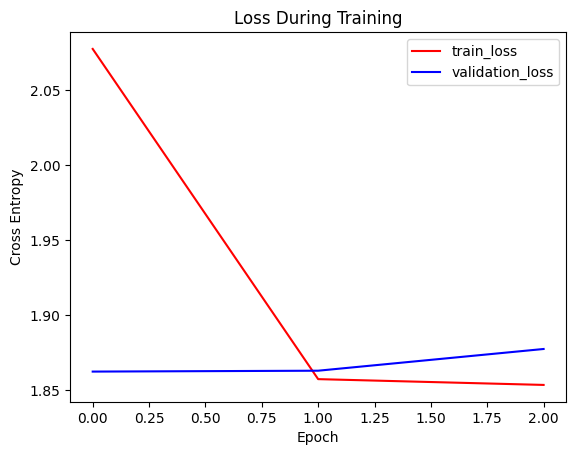

In [31]:
plt.plot(train_set_loss_log, color='red', label='train_loss')
plt.plot(validation_set_loss_log, color='blue', label='validation_loss')

plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
plt.legend()
plt.show()

In [32]:
# Word Vectors
params = list(model.parameters())
word_vectors = params[0].detach()

In [33]:
# Create a dictionary with the same order mapping
word_dict = {word: vector for word, vector in zip(unique_words, word_vectors)}

In [34]:
def cosine_similarity(v1, v2):
    return (v1 @ v2) / (torch.norm(v1) * torch.norm(v2))


def most_similar(word, word_dict, top_k=5):
    if word not in word_dict:
        raise ValueError(f"{word} not found in the word dictionary.")

    query_vector = word_dict[word]

    # Calculate cosine similarity with all other words in the dictionary
    similarities = {}
    for other_word, other_vector in word_dict.items():
        if other_word != word:
            similarity = cosine_similarity(query_vector, other_vector)
            similarities[other_word] = similarity

    # Sort the words by similarity in descending order
    sorted_similarities = sorted(
        similarities.items(), key=lambda x: x[1], reverse=True)

    # Get the top-k most similar words
    top_similar_words = sorted_similarities[:top_k]

    return top_similar_words

In [35]:
word_dict

{'animal': tensor([-0.9361,  0.1166]),
 'boy': tensor([-0.0041,  0.6971]),
 'castle': tensor([ 0.2931, -0.0789]),
 'cat': tensor([-6.8003,  0.6972]),
 'country': tensor([-0.0617, -0.1864]),
 'crown': tensor([-0.3955, -3.6957]),
 'dog': tensor([-0.9382,  0.0587]),
 'empire': tensor([ 0.1563, -0.1850]),
 'family': tensor([-0.5838,  2.1346]),
 'father': tensor([-0.2816,  0.3760]),
 'girl': tensor([-0.0125,  1.0509]),
 'house': tensor([ 0.3607, -0.9868]),
 'king': tensor([ 2.7999, -1.4589]),
 'marriage': tensor([0.1632, 1.2436]),
 'mother': tensor([0.1636, 1.8670]),
 'pet': tensor([-0.9203,  0.0356]),
 'play': tensor([-0.7011,  0.0992]),
 'queen': tensor([ 0.1251, -0.2160]),
 'rule': tensor([ 0.1112, -0.2404]),
 'sleep': tensor([-0.9291,  0.0652])}

In [36]:
word_dict['dog']

tensor([-0.9382,  0.0587])

In [37]:
most_similar('dog', word_dict)

[('sleep', tensor(1.0000)),
 ('pet', tensor(0.9997)),
 ('cat', tensor(0.9992)),
 ('animal', tensor(0.9981)),
 ('play', tensor(0.9970))]

In [38]:
most_similar('father', word_dict)

[('family', tensor(0.9302)),
 ('girl', tensor(0.8075)),
 ('boy', tensor(0.8039)),
 ('mother', tensor(0.7450)),
 ('marriage', tensor(0.7156))]

In [39]:
most_similar('queen', word_dict)

[('rule', tensor(0.9958)),
 ('house', tensor(0.9848)),
 ('empire', tensor(0.9845)),
 ('king', tensor(0.8443)),
 ('crown', tensor(0.8072))]

In [40]:
cosine_similarity(word_dict['father'], word_dict['mother'])

tensor(0.7450)

In [41]:
cosine_similarity(word_dict['family'], word_dict['empire'])

tensor(-0.9071)

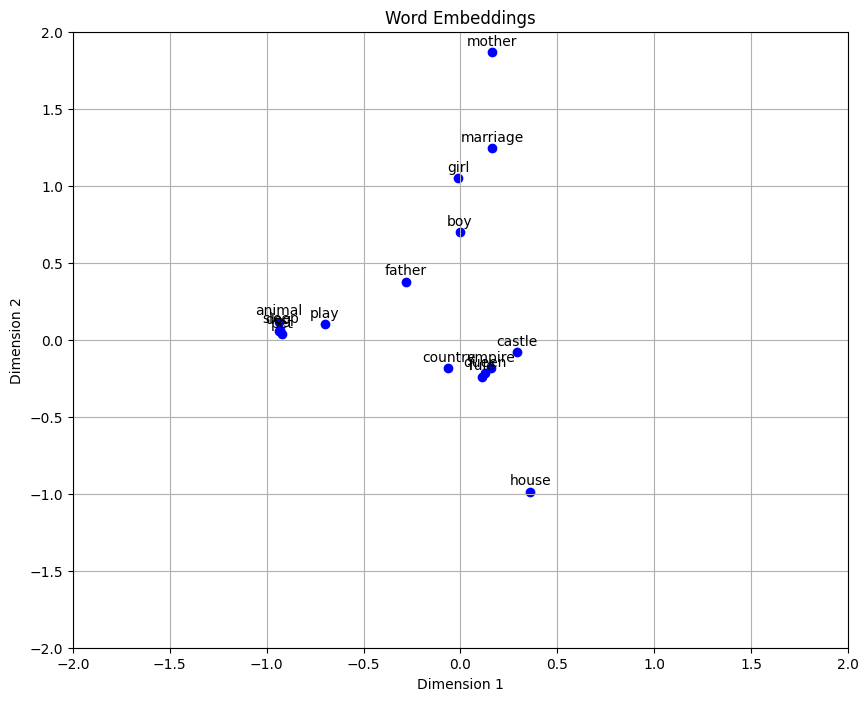

In [42]:
x_coords, y_coords = zip(*[word_dict[word].numpy()
                         for word in list(word_dict.keys())])

plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, marker='o', color='blue')

for i, word in enumerate(list(word_dict.keys())):
    plt.annotate(word, (x_coords[i], y_coords[i]),
                 textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

In [44]:
# Specify the file path where you want to save the JSON file
file_path = 'data/pretrained_word_vectors.json'

# Convert torch.Tensor objects to lists
word_vec_for_export = word_dict.copy()
for key, value in word_vec_for_export.items():
    if isinstance(value, torch.Tensor):
        word_vec_for_export[key] = value.tolist()

# Use json.dump to write the modified dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(word_vec_for_export, json_file, indent=2)

print(f'Dictionary has been exported to {file_path}')

Dictionary has been exported to data/pretrained_word_vectors.json
